Copyright (c) 2019 Asif Shakeel

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>

# Discrete time quantum walk (DTQW):  a scalable algorithm

This notebook is based on the paper "Efficient and scalable quantum walk algorithms via the quantum Fourier transform" by Asif Shakeel, [arXiv:1912.00978](https://arxiv.org/abs/1912.00978) (2019)

__Contributor__

Asif Shakeel 

email: asif.shakeel@gmail.com

__What is a DTQW and how does this algorithm work?__

You are in a world where space and time are discrete. In fact, they are both integers. Let's go for a quantum walk.

The simplest quantum walk describes a quantum particle hopping or *propagating* on a lattice (a grid) from site to site. The direction or *velocity* of the hop is stored in an internal state (think *spin* of an electron) that  undergoes *scattering* just before each hop, meaning that the direction of the hop changes each hop. This simple model once generalized has lots of applications in all sorts of things like quantum search, simulation of fundamental physics and so on. Just as a demonstration of quantum vs classical behavior, a QW shows that the idea of randomness  differs between the two by displaying a walk pattern very different than a classical random walk.

On to details. Propagation is a change in position and scattering is a change in velocity of the particle. Before we can understand that, first we need to know how  we go from a classical description of position to a quantum one? For us, the lattice is one-dimensional,  a line with $N$ sites,  with the ends wrapping around. Each of these site positions, $x \in \{0, \ldots, N-1 \}$, in a quantum setting becomes  a basis element of an $N$ dimensional *position* space,  $x \mapsto \left| x\right\rangle$. Next, the velocity. Well, let's say  we only hop on this line one step to the "left", i.e., $x \mapsto x-1$ or one step to the "right", i.e., $x \mapsto x+1$.  Then a velocity can be either $-1$ or $+1$. So we represent a velocity in a $2$-dimensional *velocity* space in which the left and right hops are basis vectors $\left|v\right\rangle$ with $v  \in \{-1,+1\}$. Let's put the two together in a composite space $\mathcal{H}$ with velocity first and then the position:


\begin{equation}
\mathcal{H} = \mathbb{C}^2 \otimes \mathbb{C}^N 
\end{equation}

If you don't know the funny symbols here, they simply mean what we just said in the paragraph before. We are now saying it formally, and we won't be needing this kind of notation except to state a few more formal things.

So what do we need? Really, just what  a qubit is.  It's a $2$-dimensional vector space, whose basis is usually taken as $\{\left|0\right\rangle, \left|1\right\rangle\}$. 

\begin{equation}
\left|0\right\rangle = \left . \begin{bmatrix}
    1 \\
    0 
  \end{bmatrix} \right.
\end{equation}

\begin{equation}
\left|1\right\rangle = \left . \begin{bmatrix}
    0 \\
    1 
  \end{bmatrix} \right.
\end{equation}

If we have $n$ *bits*, we have  $2^n$ numbers (which ones?). So if we chose them as positions of points on a line, i.e., $N=2^n$,  then when we go to their quantum versions,   $n$ qubits, we are in a  $2^n$-dimensional position space.
And the basis vector for a position $x \in \{0,\ldots,2^n-1\}$ is all zeros except at index $x$ as shown below (indices shown on the right),  where it is $1$,

\begin{equation} 
\left|x\right\rangle= 
  \begin{bmatrix}
	0 \\
 	0\\
    \vdots\\
   	0\\
   	1\\
	0\\
    \vdots\\
    0   
  \end{bmatrix}  
  \begin{array}{l}
	(0) \\
 	(1) \\
    \vdots \\
   	\phantom{0} \\
    (x)\\
	\phantom{0} \\
    \vdots \\
    \phantom{0} 
    \end{array} 
\end{equation}  

What about the velocity space? We simply make it into a qubit too by  the map $\left|+1\right\rangle \mapsto \left|0\right\rangle$, and $\left|-1\right\rangle \mapsto \left|1\right\rangle$.  So $v \in \{0,1\}$.  Warning: this is just an identification of bases, we have not yet described what  the "left/right" hops translate to.


When we put the two spaces together, creating the velocity-position space, that's
$n+1$ qubits. We give a  velocity-position basis vector the symbol $\left|v,x\right\rangle$. What do these look like? For each $v$ there are $2^n$ values of $x$, so we need a column vector that is $2^{n+1}$ long with the top $2^n$ values for $x$ values with $v=0$ and bottom $2^n$ for $x$ values with $v=1$. The basis element $\left|v,x\right\rangle$ is all zeros except at the position $2^n v+x$, where it is $1$,

\begin{equation}
\left|v,x\right\rangle= 
  \begin{bmatrix}
	0 \\
 	0\\
    \vdots\\
   	0\\
   	1\\
	0\\
    \vdots\\
    0   
  \end{bmatrix}  
  \begin{array}{l}
	(0) \\
 	(1) \\
    \vdots \\
   	\phantom{0} \\
   	(2^n v+x)\\
	\phantom{0} \\
    \vdots \\
    \phantom{0} 
    \end{array} 
\end{equation} 

We have the space set up. Now let's go on and make things evolve. Scattering is a simple operation on the velocity space alone, so it can be any $2 \times 2$ unitary  matrix, usually parametrized as 

\begin{equation}
S=\begin{bmatrix}
ie^{i\alpha}\sin\theta&e^{i\alpha}\cos\theta\\
e^{i\alpha}\cos\theta&ie^{i\alpha}\sin\theta
\end{bmatrix}.
\end{equation}

It doesn't affect the position space, so we describe it as

\begin{equation}
S \otimes \mathbb{I}_x
\end{equation}

where $\mathbb{I}_x$ is the identity on the position space. Just think of it as the map

\begin{equation}
\left| v \right \rangle \mapsto S(\left | v \right \rangle)
\end{equation}

Propagtion either shifts the position $\left|x\right\rangle$ to the right by $1$ or the left by $1$ depending on the velocity being $\left|0\right\rangle$ or  $\left|1\right\rangle$ respectively. Let's go back to the vector for $\left|x\right\rangle$ above. If we multiply it on the left by the $2^n \times 2^n$ matrix

\begin{equation} 
\mathbf{X}= 
  \begin{bmatrix}
    0&0&0&\cdots &1 \\
    1&\ddots &\ddots& \ddots &\vdots \\
    0 & \ddots&\ddots & 0&0\\
    \vdots&\ddots&1&0 & 0 \\
    0&\cdots&0&1 & 0   
  \end{bmatrix},
\end{equation}

we get

\begin{equation} 
\mathbf{X} \left|x\right\rangle = \left|x+1\right\rangle.
\end{equation}

We have our right shift. Check this for yourself and also that the left shift is obtained by   $\mathbf{X}^\top$. Then propagation we described, call it $\sigma$, is

\begin{equation} 
\sigma= 
  \begin{bmatrix}
\mathbf{X} & \bf{0} \\
    \bf{0}&\mathbf{X}^\top
  \end{bmatrix}.
\end{equation}

In the paper [arXiv:1912.00978](https://arxiv.org/abs/1912.00978) it is shown that propgation $\sigma$ can be implemented in the following way:

![velocity-controlled-shift](./q-inc.png)

(The paricular sequence used for the CNOT gates on either side does not matter).

There only remains one more thing. How do we implement the shift $\mathbf{X}$? For that we use a very elegant solution based on Quantum Fourier Transform (QFT). QFT, $\mathcal{F}$,  is

\begin{equation}
\mathcal{F} : \left|x\right\rangle \rightarrow \frac{1}{\sqrt{N}} \sum_{k=0}^{N-1} e^{2\pi i x k/N}\left| k  \right\rangle.
\end{equation}
Note: remember that $N=2^n$ for us.

Shor's QFT algorithm that we use [arXiv:9508027](https://arxiv.org/abs/quant-ph/9508027v2) is a wonderful tool and is explained in [Nielsen and Chuang](http://dx.doi.org/10.1017/CBO9780511976667).  Shift $\mathbf{X}$ is diagonalized by the QFT, and that gives us the following expression

\begin{equation}
\mathbf{X}=\mathcal{F}^{-1} \Omega \mathcal{F},
\end{equation}

where $\Omega$ is the diagonal matrix which is a product of one-qubit phase gates. The phase gate applied to qubit $j \in \{0,\ldots,n-1\}$ is

\begin{equation}
u_j=\begin{bmatrix}
    1&0\\
    0 & \omega^{2^j}
  \end{bmatrix}.
\end{equation}
and $\omega = e^{2\pi i/N}$.

Finally, we combine the scattering followed by propagation as the QW  evolution operator $R$, 

\begin{equation}
R=\sigma \circ(S\otimes \mathbb{I}_x)
\end{equation}



### QW Run!

#### Let's see how this QW does on IBM quantum computers 

In [1]:
from qiskit import * 
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor 
import matplotlib.pyplot as plt 
%matplotlib inline 
from math import pi 

#### Set up the parameters of the simulation.  

In [2]:
T=1  # Number of evolution steps
n=2  # number of lattice qubits. Lattice size is 2^n

back='ibmqx2' 

shots=1024*4            # Number of shots to run the program (experiment); maximum is 8192 shots.
max_credits = 3        # Maximum number of credits to spend on executions. 

#### Next the  qubits and the circuit. Note that we need $n+1$ qubits including the velocity qubit.  Qubits $0,\ldots, n-1$ are the lattice qubits and qubit $n$ is the velocity qubit.


In [3]:
qr = QuantumRegister(n+1, "qr")
cr = ClassicalRegister(n+1, "cr")
qwcirc = QuantumCircuit(qr, cr, name="qwcirc")

#### Define the circuits for QFT, the  inverse QFT and the phase shift we need to implement the shift $\mathbf{X}$. 

In [4]:
def qft(circ, q, n):
    """n-qubit QFT"""
    for j in range(n)[::-1]:
        circ.h(q[j])
        for k in range(j-1,-1,-1):
            circ.cu1(pi/float(2**(j-k)), q[k], q[j])

        
def qftinv(circ, q, n):
    """n-qubit IQFT"""
    for j in range(n):
        for k in range(j-1,-1,-1)[::-1]:
            circ.cu1(-pi/float(2**(j-k)), q[k], q[j]) 
        circ.h(q[j])  

def phaseshift(circ, q, n):
    """phase shift."""
    for j in range(n):
        circ.u1(2*pi/float(2**(j+1)), q[j])

#### Here we set up one step of QW evolution, scattering followed by propagation. We use the scattering matrix
\begin{equation*}
S=\frac{1}{\sqrt{2}}\begin{bmatrix}
1&i\\
i&1
\end{bmatrix}.
\end{equation*} 
#### which is applied to qr[n], the velocity qubit. 

In [5]:
def global_evolution(circ):

# SCATTERING
    circ.rx(-pi/2,qr[n])

#PROPAGATION
    for j in range(n):
        circ.cx(qr[n],qr[j])

    qft(circ, qr, n)
    phaseshift(circ,qr,n)
    qftinv(circ,qr,n)

    for j in range(n):
        circ.cx(qr[n],qr[j])

#### We start in the state with all qubits, including veloctiy qubit, in $\left| 0 \right \rangle$ state except qubit $qr[1]$ of position in $\left| 1 \right \rangle$ state, that is $x=2$.

In [6]:
# Initialize the qubits.

qwcirc.x(qr[1]) # position initialization
#qwcirc.x(qr[n]) # momentum initialization

#### We run the simulation for T steps of evolution. 

In [7]:
for t in range(T):
   global_evolution(qwcirc)
qwcirc.barrier()


#### And we measure the state. That's all... 

In [8]:
qwcirc.measure(qr, cr)

#### ..... except for the simulation.

### Simulator 
#### Try the algorithm on the simulator first

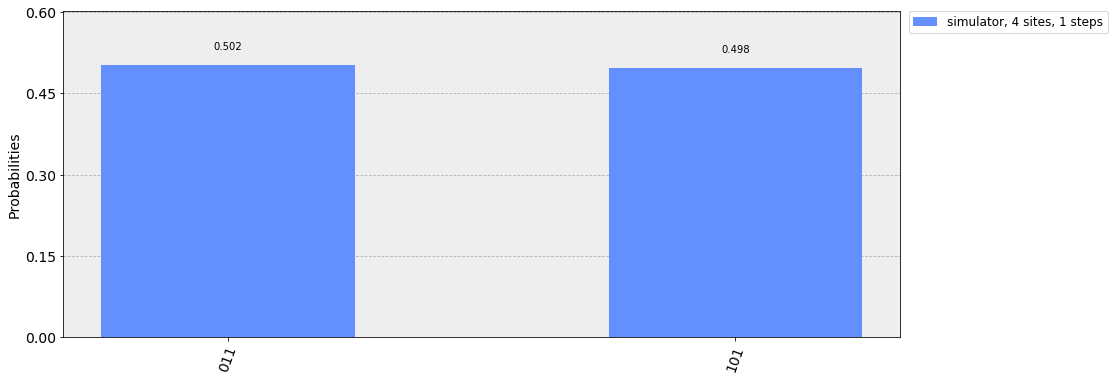

In [9]:
from qiskit.providers.aer.noise import NoiseModel
noise_model = NoiseModel()
from qiskit.providers.aer import QasmSimulator

#simulator = QasmSimulator()
simulator = Aer.get_backend('qasm_simulator')
job = execute(qwcirc, backend=simulator, shots=shots)
result = job.result()

## Then, plot a histogram of the results
counts = result.get_counts(qwcirc)
from qiskit.tools.visualization import plot_histogram
title='simulator' +', '+str(2**n)+' sites, '+str(T)+' steps'
plot_histogram([counts],
               figsize=(15,6),
               legend=[title])


#### The above distribtion of velocity-position state is what we would expect.

#### Note: for the lattice size of  $4$ ($n=2$) and $T=1$ step of evolution that we have chosen, we see that the state is equally likely one of these: velocity is $0$ (right shift) when position is $11$  and the velocity is $1$ (left shift) when position is $01$. For other parameter choices, the distribution would be different.

### Quantum computer
#### Let's try it on a quantum computer

In [10]:
## Use your generated API_KEY from IBM Q account

#IBMQ.save_account(API_KEY)
#IBMQ.enable_account(API_KEY)

In [11]:
IBMQ.load_account()
provider = IBMQ.get_provider(group='open')

In [12]:
backend = provider.get_backend(back)
jobc = execute(qwcirc, backend,shots=shots)
job_monitor(jobc)

Job Status: job has successfully run


In [13]:
countsc = jobc.result().get_counts()

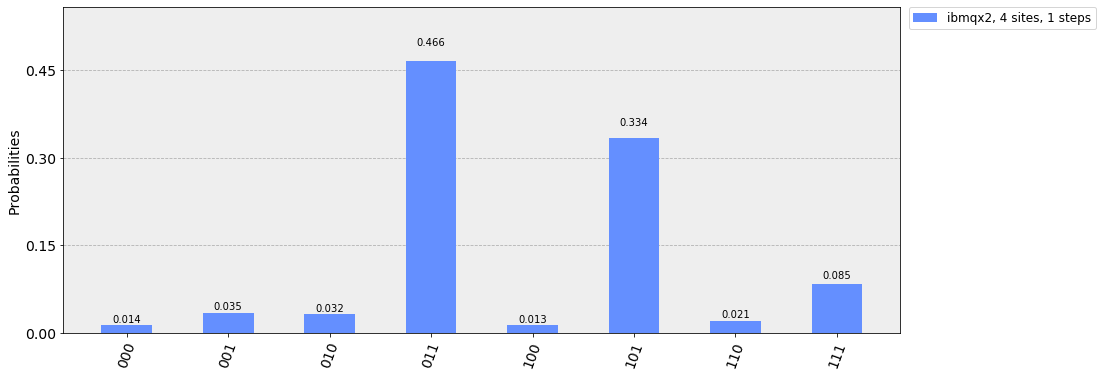

In [14]:
title=back+', '+str(2**n)+' sites, '+str(T)+' steps'
plot_histogram([countsc],
               figsize=(15,6),
               legend=[title])

#### The quantum computer run above shows good agreement with the simulated run, despite  the noise and other effects. 